In [1]:
from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import os
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.modeling.models import Schechter1D
import astropy.constants as c
import pandas as pd

In [2]:
from matplotlib import rc                # Establece parámetros iniciales al grupo
rc('text', usetex=False)
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25
plt.rc('font', family='serif')
plt.rc('font', size=SMALL_SIZE)          # Controla tamaño de texto por defecto
plt.rc('axes', titlesize=BIGGER_SIZE)    # Tamaño de las fuentes de los títulos
# Tamaño de las fuentes de los ejes x e y
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)    # Tamaño de los tick en el eje x
plt.rc('ytick', labelsize=SMALL_SIZE)    # Tamaño de los tick en el eje y
plt.rc('legend', fontsize=SMALL_SIZE)    # Tamaño de las leyendas
# Tamaño de la fuente del título de la figura
plt.rc('figure', titlesize=BIGGER_SIZE)

In [3]:
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3) # Create a universe model

In [4]:
def sc_func(phis,Ls,L,alpha):
    phi = (phis/Ls)*(L/Ls)**(alpha) * np.exp(-(L/Ls))
    return phi

In [5]:
def volume_redshift(z, area):
    "Obstains the volume given a minimum and maximum redshift, using the cosmology comoving distance"
#     D_min = cosmo.luminosity_distance(z_min)
#     D_max = cosmo.luminosity_distance(z_max)

    err = 0.01
#     D_min = cosmo.comoving_distance(z-err)
#     D_max = cosmo.comoving_distance(z + err)
#     D_mid = cosmo.comoving_distance(z)

    #M = mag - 5 * np.log10(D_mid/(10 * (u.pc)))

    #m_lim = 24.98
    #d = 10*(u.pc) * 10**((m_lim-M)/5)

    #if (d > D_min) & (d < D_max):
       # volume = 4/3 * np.pi * (d ** 3 - D_min**3) * (area/(180*360))

    #else:
    #volume = 4/3 * np.pi * (D_max ** 3 - D_min**3) * (area/(180*360))
    
    radianes = (area * (np.pi / 180)**2)
    volume = (cosmo.comoving_volume(z+err) - cosmo.comoving_volume(z-err))*(radianes/4*np.pi)
    
    return volume.value 

In [104]:
def flux_lum(z, area, flux):
    
    # Convert from F_nu to F_lambda
    f_lam = []
    for f, f_nu in enumerate(flux):
        wavelength = 9640*u.AA #AA
        c_s = ac.c.to(u.AA/u.s)
        f_n = (f_nu*u.Jy*1e-6).to(u.erg/u.s/u.cm**2/u.Hz)
        f_lambda = ((c_s / wavelength**2) * f_n)
        f_lam.append(f_lambda.value)
        #print(f_lambda) #erg / (Angstrom cm2 Hz s2)
    
    f_lam = np.array(f_lam)
    f_lam = f_lam*u.erg/u.AA/u.cm**2/u.s
    phi = []
    lum = []
    lum_log = []
    for j, flux_ in enumerate(f_lam):

        D = cosmo.luminosity_distance(z)
        d_cm = D.to(u.cm)
        L = flux_*(4*np.pi*(d_cm**2))
        lum.append(L.value)
        print(L)
        lum_log.append(np.log10(L.value))
    
    
    bin_size = 0.5
    lum_log = np.array(lum_log)
    numbers = np.arange(np.min(lum_log), np.max(lum_log), bin_size)
    print('Bines: '+ str(len(numbers)))
    for i, n in enumerate(numbers):
        # print(n)
        mask = (lum_log >= n) & (lum_log < n+ bin_size)
        bin_log = lum_log[mask]
        print('Bin '+str(i)+': '+str(len(bin_log)))
        #vol_tot = []
        vol = volume_redshift(z, area)
#         for i, magn in enumerate(bin_mag):
#             vol = volume_redshift(z, area, magn)
#             vol_tot.append(1/vol)

        #phi.append(sum(vol_tot))
        phi.append((1/vol)*len(bin_log))
    phi = np.array(phi)
    lum_phi = phi/bin_size
    
    return numbers, lum_phi, lum_log

In [7]:
def lum_func(z, area, mag):

    phi = []
    mag_abs = []
    for j, mag_ap in enumerate(mag):

        D_mid = cosmo.luminosity_distance(z)
        M = mag_ap - 5*np.log10(D_mid/(10 * (u.pc)))
        mag_abs.append(M)
    
    bin_size = 0.5
    mag_abs = np.array(mag_abs)
    numbers = np.arange(np.min(mag_abs), np.max(mag_abs), bin_size)
    print('Bines: '+ str(len(numbers)))
    for i, n in enumerate(numbers):
        # print(n)
        mask = (mag_abs >= n) & (mag_abs < n+ bin_size)
        bin_mag = mag_abs[mask]
        print('Bin '+str(i)+': '+str(len(bin_mag)))
        #vol_tot = []
        vol = volume_redshift(z, area)
#         for i, magn in enumerate(bin_mag):
#             vol = volume_redshift(z, area, magn)
#             vol_tot.append(1/vol)

        #phi.append(sum(vol_tot))
        phi.append((1/vol)*len(bin_mag))
        

    return numbers, phi, mag_abs

In [83]:
table = Table.read('combined.fits')
table2 = Table.read('NSF1_Bagpipes_NO_AGN.fits')

In [9]:
def lum_mag(lum):
    result =  -2.5*np.log10(lum/3.846e33)
    return result

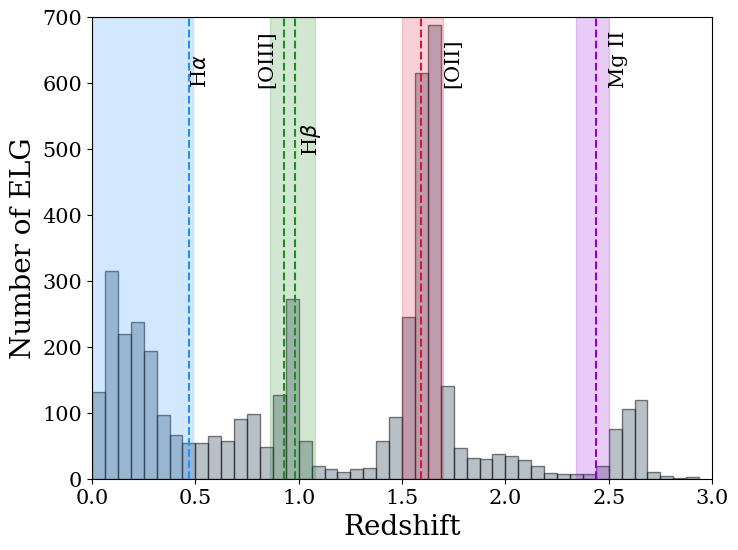

In [10]:
fig,ax=plt.subplots(figsize=(8,6), dpi=100)

bins = np.arange(0,3,0.0625)


ax.hist(table['redshift_50'], bins =bins, histtype ='bar', alpha = 0.5, 
         color = 'slategray',ec = 'k')
ax.vlines(0.47,0,1000, linestyle ='dashed', color = 'dodgerblue')
ax.axvspan(0, 0.49, alpha=0.2, color='dodgerblue')
ax.text(0.48, 600, r'H$\alpha$', size = 15, rotation='vertical')

ax.vlines(0.98,0,1000, linestyle ='dashed', color = 'forestgreen')
#ax.axvspan(0.86,1.05, alpha=0.2, color='forestgreen')
ax.text(1, 500, r'H$\beta$', size = 15, rotation='vertical')

ax.vlines(0.93,0,1000, linestyle ='dashed', color = 'forestgreen')
ax.axvspan(0.86, 1.08, alpha=0.2, color='forestgreen')
ax.text(0.8, 600, r'[OIII]', size = 15, rotation='vertical')

ax.vlines(1.59,0,1000, linestyle ='dashed', color = 'crimson')
ax.axvspan(1.5, 1.7, alpha=0.2, color='crimson')
ax.text(1.7, 600, r'[OII]', size = 15, rotation='vertical')


ax.vlines(2.44,0,1000, linestyle ='dashed', color = 'darkviolet')
ax.axvspan(2.34, 2.5, alpha=0.2, color='darkviolet')
ax.text(2.5, 600, r'Mg II', size = 15, rotation='vertical')

#plt.vlines(0.2,0,1000, linestyle ='dashed', color = 'crimson')
ax.set_xlim(0,3)
ax.set_ylim(0,700)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of ELG')
plt.show()

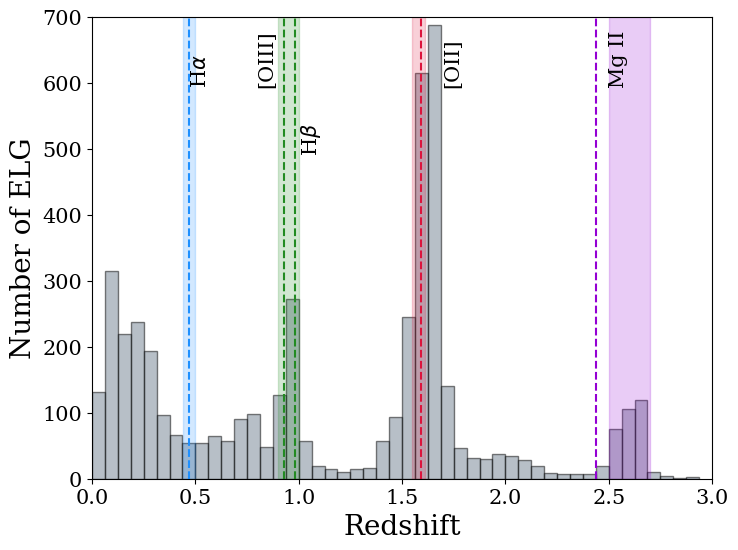

In [11]:
fig,ax=plt.subplots(figsize=(8,6), dpi=100)

bins = np.arange(0,3,0.0625)


ax.hist(table['redshift_50'], bins =bins, histtype ='bar', alpha = 0.5, 
         color = 'slategray',ec = 'k')
ax.vlines(0.47,0,1000, linestyle ='dashed', color = 'dodgerblue')
ax.axvspan(0.44, 0.5, alpha=0.2, color='dodgerblue')
ax.text(0.48, 600, r'H$\alpha$', size = 15, rotation='vertical')

ax.vlines(0.98,0,1000, linestyle ='dashed', color = 'forestgreen')
#ax.axvspan(0.86,1.05, alpha=0.2, color='forestgreen')
ax.text(1, 500, r'H$\beta$', size = 15, rotation='vertical')

ax.vlines(0.93,0,1000, linestyle ='dashed', color = 'forestgreen')
ax.axvspan(0.9, 1.0, alpha=0.2, color='forestgreen')
ax.text(0.8, 600, r'[OIII]', size = 15, rotation='vertical')

ax.vlines(1.59,0,1000, linestyle ='dashed', color = 'crimson')
ax.axvspan(1.55, 1.61, alpha=0.2, color='crimson')
ax.text(1.7, 600, r'[OII]', size = 15, rotation='vertical')


ax.vlines(2.44,0,1000, linestyle ='dashed', color = 'darkviolet')
ax.axvspan(2.5, 2.7, alpha=0.2, color='darkviolet')
ax.text(2.5, 600, r'Mg II', size = 15, rotation='vertical')

# ax.vlines(2.44,0,1000, linestyle ='dashed', color = 'crimson')
# ax.axvspan(1.30, 1.9, alpha=0.2, color='crimson')
# ax.text(2.5, 650, r'MgII', size = 15, rotation='vertical')

#plt.vlines(0.2,0,1000, linestyle ='dashed', color = 'crimson')
ax.set_xlim(0,3)
ax.set_ylim(0,700)
ax.set_xlabel('Redshift')
ax.set_ylabel('Number of ELG')
plt.show()

#  H-$\alpha$

In [12]:
#Stand-by

In [52]:
#mask1 =  (0.4 < table['redshift_50']) & (table['redshift_50'] < 0.55)
mask1 =  (0 < table['redshift_50']) & (table['redshift_50'] < 0.49)
H_a = table[mask1]

In [84]:
#mask1b =  (0.44 < table['redshift_50']) & (table['redshift_50'] < 0.5)
mask1b =  (0 < table2['redshift_50']) & (table2['redshift_50'] < 0.49)
H_ab = table2[mask1b]

In [85]:
phi_star = 10**(-3.16) * (u.Mpc ** -3)
l_star = (10**(41.72))
m_star = lum_mag(10**(41.72))
alpha = -1.75
model = Schechter1D(phi_star, m_star, alpha)

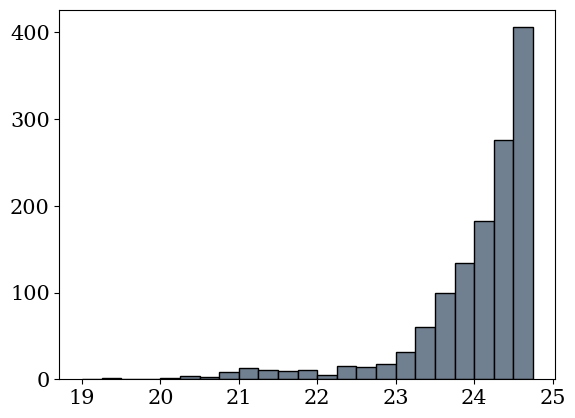

In [86]:
aper =2

NB_1 = np.array([H_a['MAG_APER_1'][i][aper] for i in range(len(H_a))]) 
NB_1b = np.array([H_ab['MAG_APER_1'][i][aper] for i in range(len(H_ab))]) 


bins1 = np.arange(19, 25, 0.25)
plt.hist(NB_1, bins = bins1 ,color = 'slategray',ec = 'k')
#plt.xlim(22,25)
plt.show()

In [87]:
a = lum_func(0.47, 2.94, NB_1)

Bines: 11
Bin 0: 1
Bin 1: 2
Bin 2: 11
Bin 3: 24
Bin 4: 21
Bin 5: 18
Bin 6: 24
Bin 7: 68
Bin 8: 189
Bin 9: 368
Bin 10: 576


In [88]:
a2 = lum_func(0.47, 2.94, NB_1b)

Bines: 11
Bin 0: 1
Bin 1: 2
Bin 2: 11
Bin 3: 24
Bin 4: 21
Bin 5: 18
Bin 6: 24
Bin 7: 68
Bin 8: 189
Bin 9: 368
Bin 10: 576


In [89]:
NB_1c = np.array([H_a['FLUX_APER_1'][i][aper] for i in range(len(H_a))])
a3 = flux_lum(0.47, 2.94, NB_1c)

Bines: 5
Bin 0: 1106
Bin 1: 131
Bin 2: 48
Bin 3: 16
Bin 4: 1


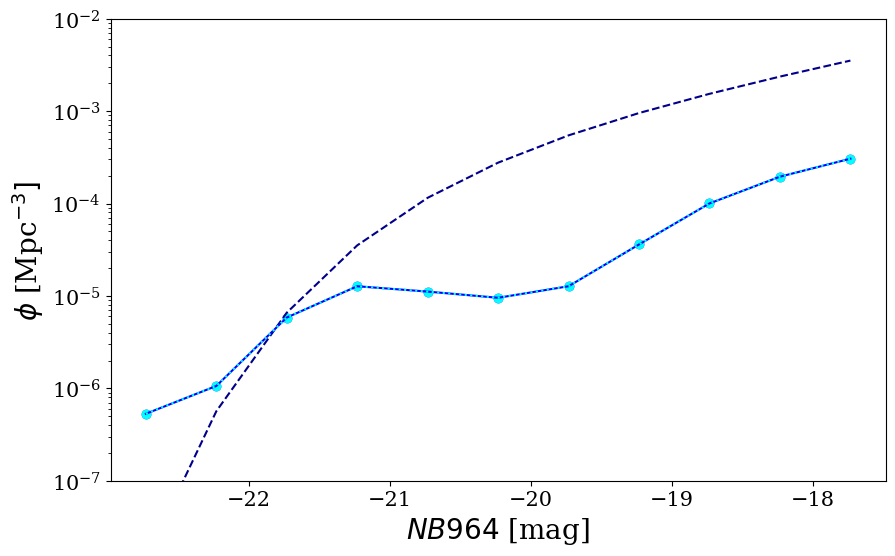

In [90]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(a[0], (model(a[0])), color = 'darkblue', linestyle = 'dashed')

ax.scatter(a[0], a[1], color = 'blue')
ax.plot(a[0], a[1], color = 'blue')

ax.scatter(a2[0], a2[1], color = 'cyan')
ax.plot(a2[0], a2[1], color = 'cyan', linestyle = 'dotted')

ax.set_yscale('log')
#ax.set_xlim(20, 30)
ax.set_ylim(10e-8,10e-3)
ax.set_xlabel('$NB964$ [mag]')
ax.set_ylabel('$\phi$ [Mpc$^{-3}]$')
plt.show()

In [91]:
# fig, ax = plt.subplots(figsize=(10, 6))

# ax.scatter(a3[0], a3[1], color = 'blue')
# ax.plot(a3[0], a3[1], color = 'blue')

# ax.set_yscale('log')
# #ax.set_xlim(20, 30)
# ax.set_ylim(10e-8,10e-3)
# ax.set_xlabel('$NB964$ [mag]')
# ax.set_ylabel('$\phi$ [Mpc$^{-3}]$')
# plt.show()

# OIII

Z = 0.93

In [22]:
mask2 =  (0.86 < table['redshift_50']) & (table['redshift_50'] <  1.08)
#mask2 = (0.7 < table['Z_BEST'] ) & (table['Z_BEST'] < 1.15)
O_III = table[mask2]

In [92]:
#mask2b =  (0.9 < table['redshift_50']) & (table['redshift_50'] <  1.0)
mask2b =  (0.86 < table2['redshift_50']) & (table2['redshift_50'] <  1.08)
#mask2 = (0.7 < table['Z_BEST'] ) & (table['Z_BEST'] < 1.15)
O_IIIb = table2[mask2b]

In [93]:
phi_star2 = 10**(-2.16) * (u.Mpc ** -3)
m_star2 = lum_mag(10**(41.38))
alpha2 = -1.60
model2 = Schechter1D(phi_star2, m_star2, alpha2)

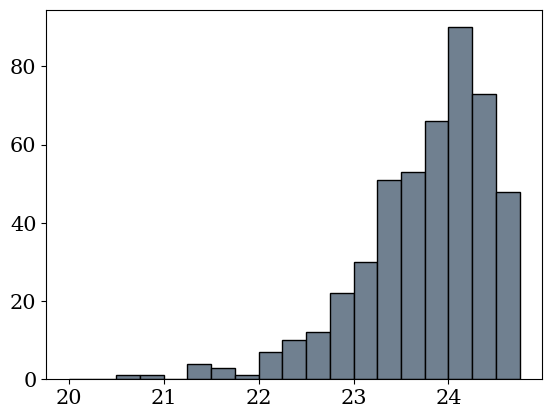

In [94]:
NB_2 = np.array([O_III['MAG_APER_1'][i][aper] for i in range(len(O_III))]) 

NB_2b = np.array([O_IIIb['MAG_APER_1'][i][aper] for i in range(len(O_IIIb))]) 
bins2 = np.arange(20, 25, 0.25)
plt.hist(NB_2, bins =bins2, color = 'slategray',ec = 'k')
#plt.xlim(22,25)
plt.show()

In [95]:
b = lum_func(0.93, 2.94, NB_2)

Bines: 9
Bin 0: 2
Bin 1: 5
Bin 2: 5
Bin 3: 23
Bin 4: 46
Bin 5: 95
Bin 6: 144
Bin 7: 149
Bin 8: 3


In [96]:
b2 = lum_func(0.93, 2.94, NB_2b)

Bines: 9
Bin 0: 2
Bin 1: 5
Bin 2: 5
Bin 3: 23
Bin 4: 46
Bin 5: 95
Bin 6: 144
Bin 7: 149
Bin 8: 3


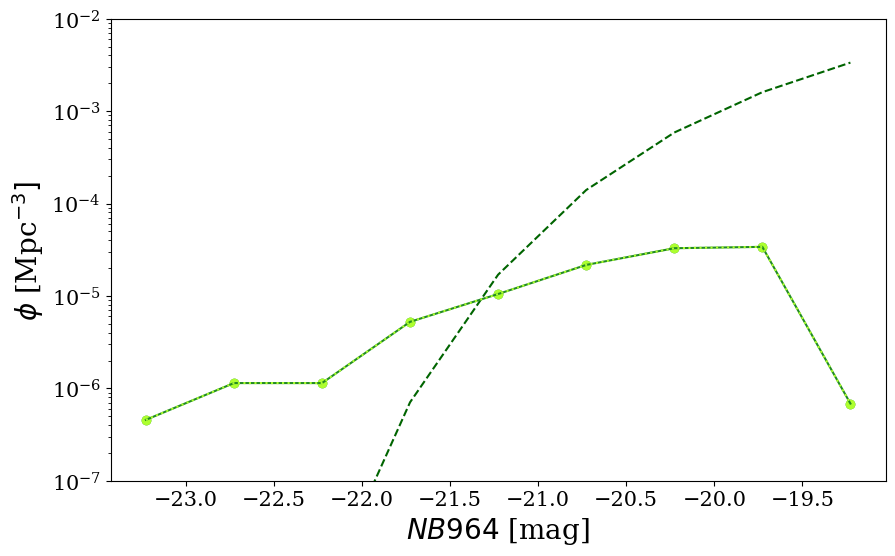

In [97]:
fig, ax = plt.subplots(figsize=(10, 6))


ax.plot(b[0], (model2(b[0])), color = 'darkgreen', linestyle = 'dashed')

ax.scatter(b[0], b[1], color = 'forestgreen')
ax.plot(b[0], b[1], color = 'forestgreen')

ax.scatter(b2[0], b2[1], color = 'greenyellow')
ax.plot(b2[0], b2[1], color = 'greenyellow', linestyle = 'dotted')


ax.set_yscale('log')
ax.set_ylim(1e-7, 1e-2)
ax.set_xlabel('$NB964$ [mag]')
ax.set_ylabel('$\phi$ [Mpc$^{-3}]$')
plt.show()

# OII

In [74]:
#mask3 =  (1.55 < table['redshift_50']) & (table['redshift_50'] < 1.61)
#mask3 = (1.3 < table['Z_BEST'] ) & (table['Z_BEST'] < 1.9)
mask3 =  (1.5 < table['redshift_50']) & (table['redshift_50'] < 1.7)
O_II = table[mask3]

In [98]:
# mask3b =  (1.5 < table['redshift_50']) & (table['redshift_50'] < 1.7)
mask3b =  (1.5 < table2['redshift_50']) & (table2['redshift_50'] < 1.7)
O_IIb = table2[mask3b]

In [99]:
phi_star3 = 10**(-1.97) * (u.Mpc ** -3)
m_star3 = lum_mag(10**(41.66))
alpha3 = -1.30
model3 = Schechter1D(phi_star3, m_star3, alpha3)

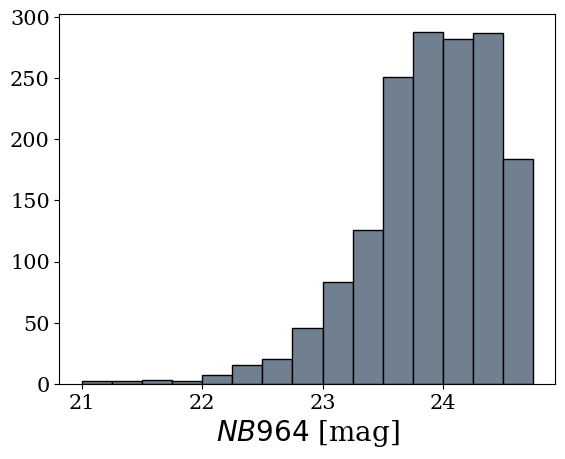

In [100]:
NB_3= np.array([O_II['MAG_APER_1'][i][aper] for i in range(len(O_II))]) 
NB_3b= np.array([O_IIb['MAG_APER_1'][i][aper] for i in range(len(O_IIb))]) 
bins3 = np.arange(21, 25, 0.25)
plt.hist(NB_3, bins =bins3, color = 'slategray',ec = 'k')
#plt.xlim(22,25)
plt.xlabel('$NB964$ [mag]')
plt.show()

In [101]:
c = lum_func(1.59, 2.94, NB_3)

Bines: 12
Bin 0: 2
Bin 1: 1
Bin 2: 3
Bin 3: 4
Bin 4: 3
Bin 5: 5
Bin 6: 14
Bin 7: 38
Bin 8: 146
Bin 9: 429
Bin 10: 567
Bin 11: 397


In [102]:
c2 = lum_func(1.59, 2.94, NB_3b)

Bines: 12
Bin 0: 2
Bin 1: 1
Bin 2: 3
Bin 3: 4
Bin 4: 3
Bin 5: 5
Bin 6: 14
Bin 7: 38
Bin 8: 146
Bin 9: 429
Bin 10: 567
Bin 11: 397


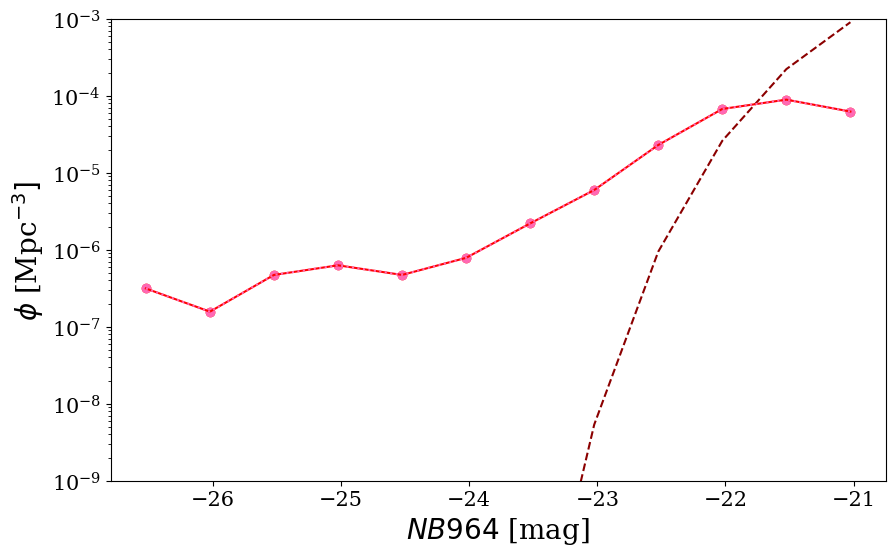

In [103]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(c[0], (model3(c[0])), color = 'darkred', linestyle = 'dashed')

ax.scatter(c2[0], c2[1], color = 'red')
ax.plot(c2[0], c2[1], color = 'red')



ax.scatter(c[0], c[1], color = 'hotpink')
ax.plot(c[0], c[1], color = 'hotpink', linestyle = 'dotted')

ax.set_yscale('log')
ax.set_ylim(1e-9, 1e-3)
#ax.set_xlim(20, 30)
ax.set_xlabel('$NB964$ [mag]')
ax.set_ylabel('$\phi$ [Mpc$^{-3}]$')
plt.show()

# Mg II

In [81]:
mask4 =  (2.34 < table['redshift_50']) & (table['redshift_50'] < 2.5)
#mask3 = (1.3 < table['Z_BEST'] ) & (table['Z_BEST'] < 1.9)
Mg_II = table[mask4]

In [37]:
mask4b =  (2.5 < table['redshift_50']) & (table['redshift_50'] < 2.7)
#mask3 = (1.3 < table['Z_BEST'] ) & (table['Z_BEST'] < 1.9)
Mg_IIb = table[mask4b]

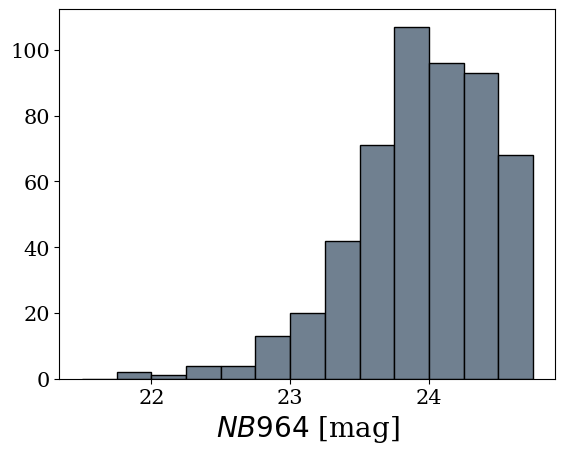

In [38]:
NB_4= np.array([Mg_II['MAG_APER_1'][i][aper] for i in range(len(Mg_II))]) 
NB_4b= np.array([Mg_IIb['MAG_APER_1'][i][aper] for i in range(len(Mg_IIb))]) 

bins4 = np.arange(21.5, 25, 0.25)
plt.hist(NB_3, bins =bins4, color = 'slategray',ec = 'k')
#plt.xlim(22,25)
plt.xlabel('$NB964$ [mag]')
plt.show()

In [39]:
d = lum_func(2.44, 2.94, NB_4)

Bines: 7
Bin 0: 11
Bin 1: 1
Bin 2: 5
Bin 3: 4
Bin 4: 2
Bin 5: 5
Bin 6: 2


In [40]:
d2 = lum_func(2.44,2.94, NB_4b)

Bines: 8
Bin 0: 6
Bin 1: 20
Bin 2: 37
Bin 3: 55
Bin 4: 71
Bin 5: 67
Bin 6: 36
Bin 7: 15


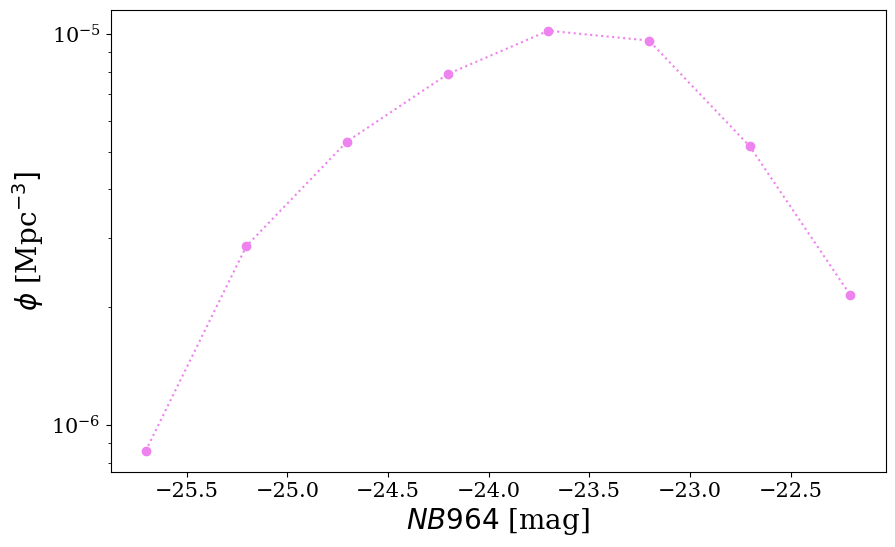

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))

#ax.plot(c[0], (model3(c[0])), color = 'darkviolet', linestyle = 'dashed')

# ax.scatter(c2[0], c2[1], color = 'red')
# ax.plot(c2[0], c2[1], color = 'red')

# ax.scatter(d[0], d[1], color = 'mediumorchid')
# ax.plot(d[0], d[1], color = 'mediumorchid')

ax.scatter(d2[0], d2[1], color = 'violet')
ax.plot(d2[0], d2[1], color = 'violet', linestyle = 'dotted')

ax.set_yscale('log')
#ax.set_ylim(1e-7, 1e-1)
#ax.set_xlim(20, 30)
ax.set_xlabel('$NB964$ [mag]')
ax.set_ylabel('$\phi$ [Mpc$^{-3}]$')
plt.show()